# Johnson noise

Resistors have an intrinsic voltage or current noise, called "Johnson noise", that contributes to a bolometers overall noise.  Here we concern ourselves with the noise from two resistors:  the bolometer itself, and the "shunt" resistor that is used (for superconducting TES bolometers) in parallel with the bolometer to develop the desired voltage bias.  <br>
<br>
We want to calculate the "Noise Equivalent Power", or NEP, for these noise sources.  That is rms power dissipated in the bolometer that a signal will need to have in order to be detected with S/N = 1.  As mentioned above, Johnson noise is natively a voltage or current noise, so we'll need to convert it to power using the bolometer's responsivity. 
<br><br>
There are a variety of treatments of the Johnson noise for these resistors in the literature;  we'll be investigating here whether these noise components are important, and whether the various treatments give consistent answers.
<br><br>
Now let's look now at two equivalent representations of the bias circuit.

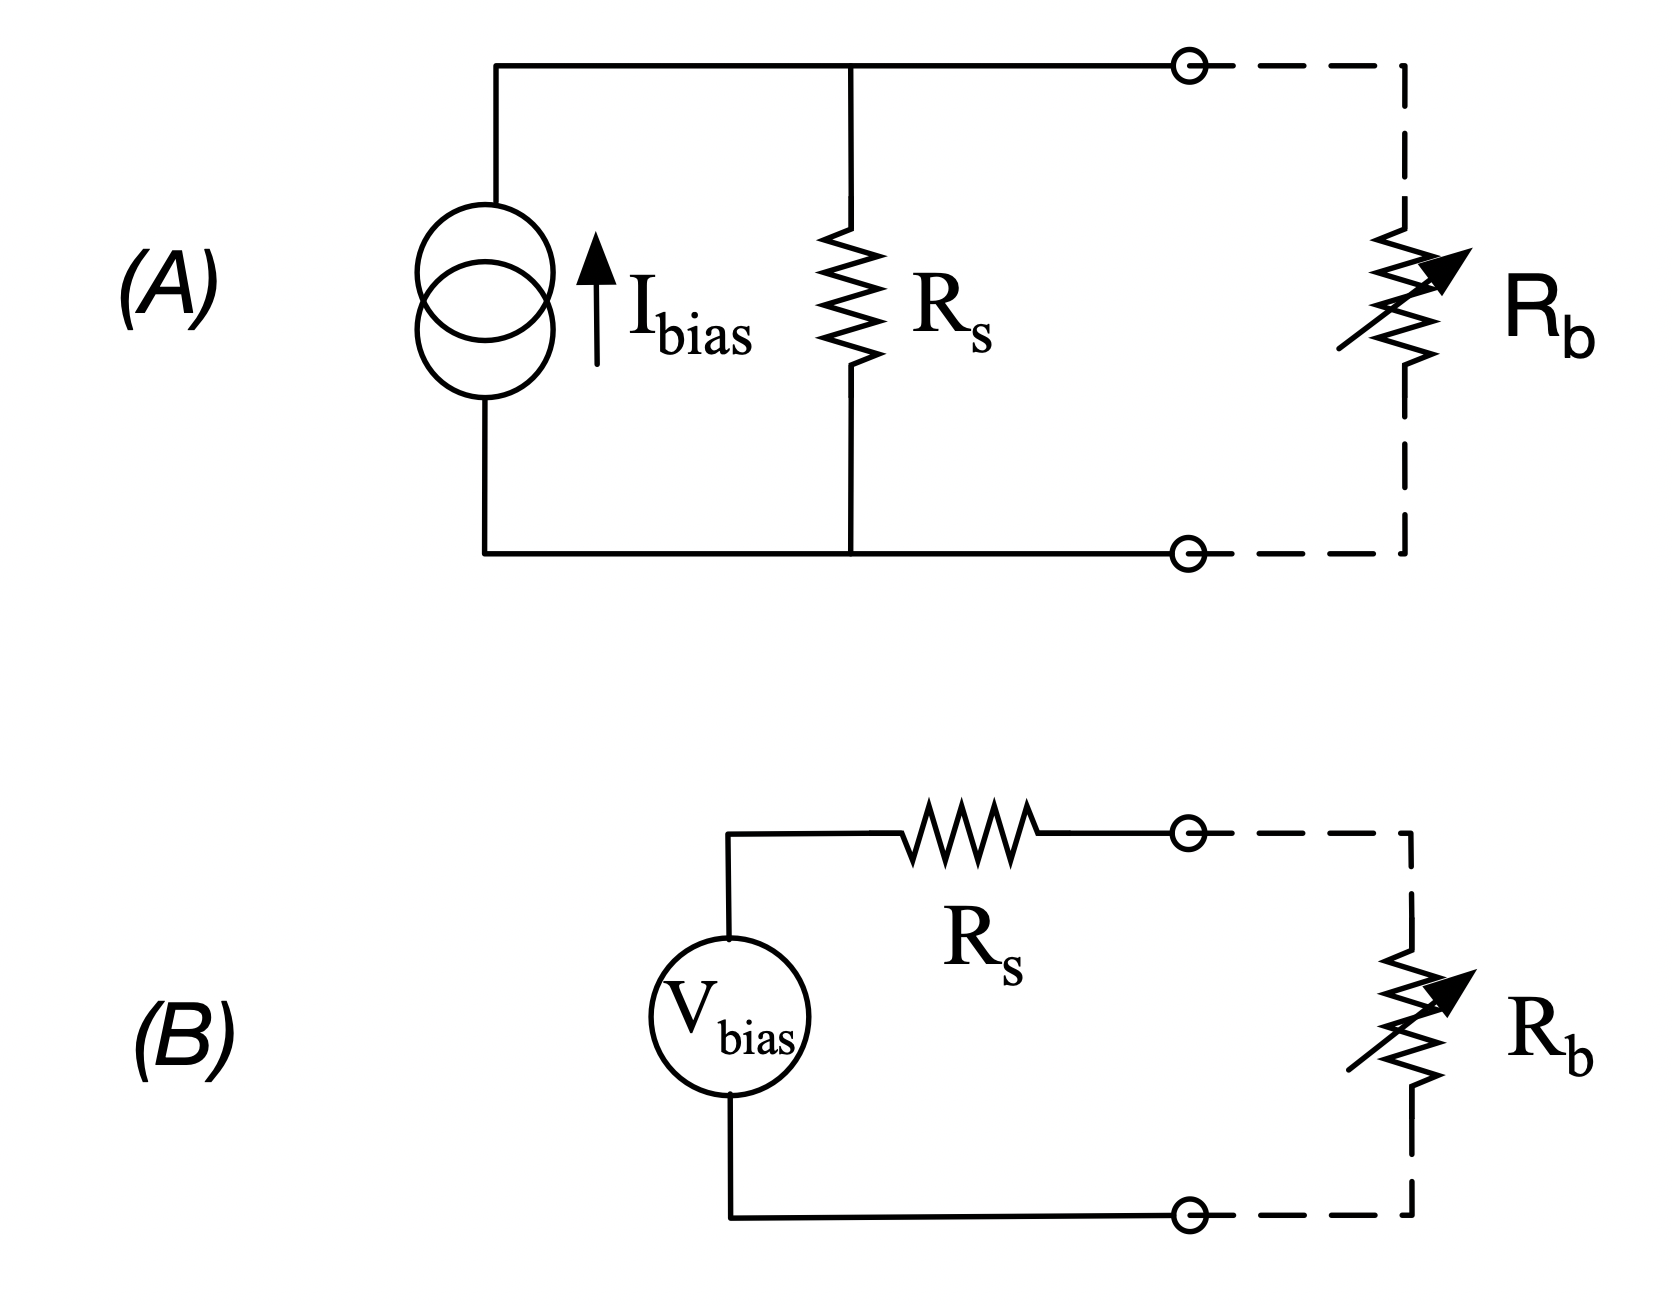

In [106]:
from IPython.display import Image
Image(filename = "img/BoloBiasCircuits.png", width = 600, height = 300)

In the figure above, the top panel (A) shows the typical bias circuit for a TES bolometer.  This uses a current bias and a shunt resistor, with $R_s \ll R_b$, to produce a voltage bias across the bolometer.  This circuit is Thevenin/Norton equivalent to the arrangement shown in (B), with $V_{bias} = I_{bias}/R_s$. <BR>
<BR>
Many of the papers on bolometers assume a circuit configuration like (B), because that was the norm for semiconductor bolometers with a large $R_b$ and even larger $R_s$.  We can, nonetheless, use the results quoted in those papers because of this Thevenin equivalence.

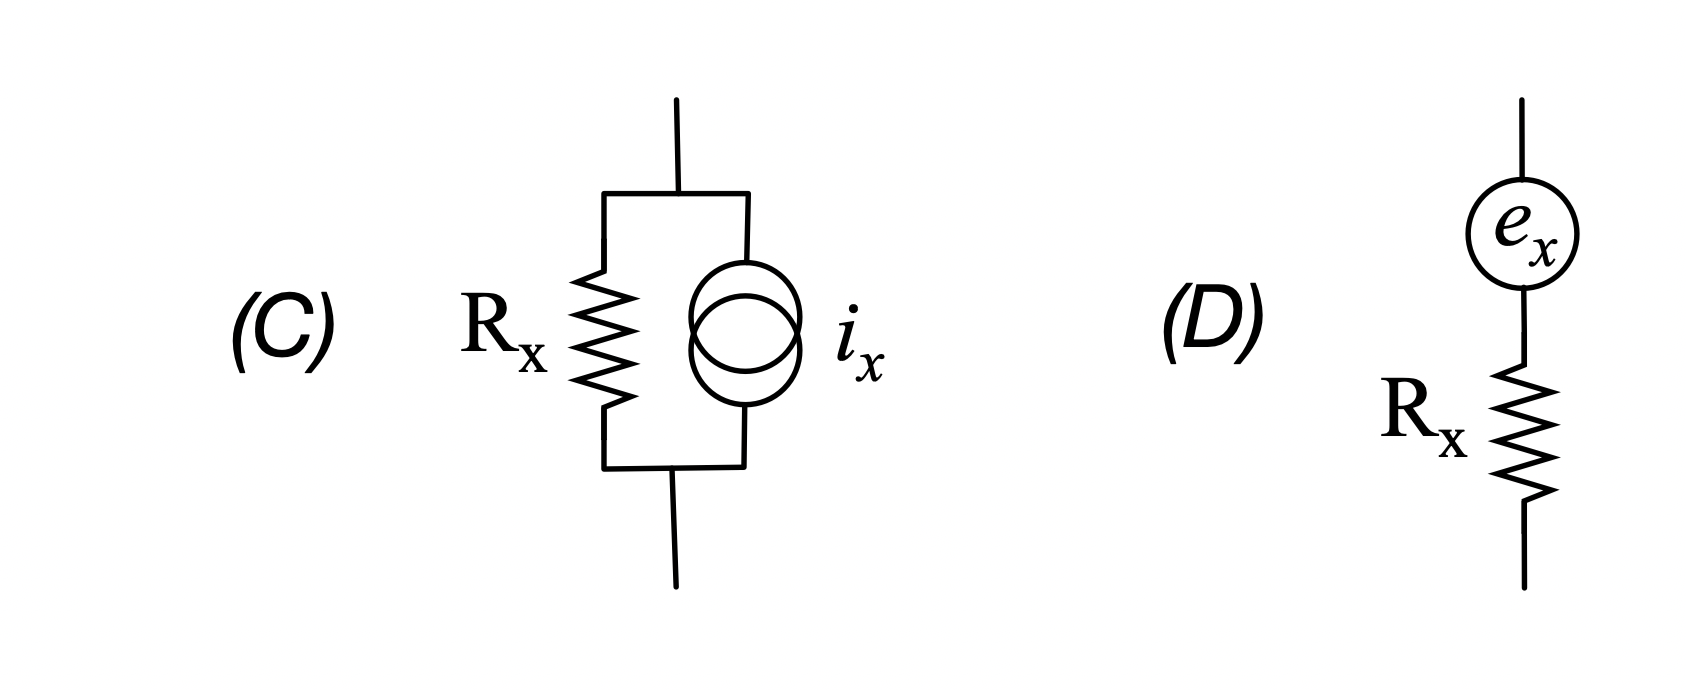

In [107]:
Image(filename = "img/NoisyResistors.png", width = 600, height = 200)

The figure above shows the two ways of thinking about Johnson noise in either resistor (shunt or bolometer).  In (C) there is a noiseless resistor in parallel with a current noise source $i_x$, while in (D) there is a noiseless resistor in series with a voltage noise source $e_x$.  We can choose whichever combination of circuits (A) and (B), and noisy resistor representations (C) and (D), makes it easiest for us to think about or model our circuit.

Given that introduction to the basic ideas, now let's set up our system parameters.

# Naiive model
The canonical model for the Johnson current noise of a resistor at temperature $T$ is
$NEI = \sqrt{4 k T/R}$, or $NEV = \sqrt{4 k T R}$.  We can use the current-to-power responsivity to convert the former to 
$NEP = \frac{1}{S_I}\sqrt{4 k T/R} $. <BR>
    
Inserting such a noisy resistor in the bias circuits above does not lead to all the noise showing up in the current measured below the bolometer, because of the division of current between various paths and because of electrothermal feedback in the bolometer.
    

    
Let's calculate these for a typical "CMB-S4" style bolometer, and compare them with a simple estimate of phonon noise.  We start by defining the detector parameters.

In [108]:
import numpy as np
import matplotlib.pyplot as plt
# 
k = 1.38e-23
#
expt = 'CMBS4'
#expt = 'Bicep'

if (expt=='CMBS4'):
    R_b = 0.006    # Bolometer operating resistance, from J. Filippini
    T_bolo = 0.160   # Bolometer temperature
    T_bath = 0.100
    R_s = 0.0004    # Shunt resistance, from J. Filippini
    T_shunt = T_bath      # Temperature of shunt resistaor, which is on the cold plate.

if (expt == 'Bicep'):
    R_b = 0.050
    T_bolo = 0.5
    T_bath = 0.25
    R_s = 0.004
    T_shunt = T_bath

#
L0 = 20        # Electro thermal feedback loop gain
n = 1.0 #2.7
beta = n-1
Tratio = T_bath/T_bolo
Flink = (beta+1)/(2*beta+3) * (1-Tratio**(2*beta+3))/(1-Tratio**(beta+1))
#
Poptical = 1e-12
Pelec = 2*Poptical  # Electrical power applied to bolometer
Vbolo = np.sqrt(Pelec*R_b)  # voltage bias on bolometer
S_I = 1/Vbolo  # current responsivity, dI/dP
#
# Things relevant to phonon noise

Psat = Poptical + Pelec   # saturation power
kfactor = Psat/(T_bolo**n - T_shunt**n)
Gdyn = n*kfactor*T_bolo**(n-1.)  # Dynamic Gdyn = dP/dTbolo

In [109]:
# Calculate noises
NEP_J_bolo = (1/(L0*S_I)) * np.sqrt(4*k*T_bolo/R_b)
NEP_J_shunt = (1/(S_I)) * np.sqrt(4*k*T_shunt/R_s)
NEP_phonon = np.sqrt(4*k*T_bolo**2*Gdyn)

print('NEP_J_bolo = {0:2.2e}'.format(NEP_J_bolo))
print('NEP_J_shunt = {0:2.2e}'.format(NEP_J_shunt))
print('NEP_phonon = {0:2.2e}'.format(NEP_phonon))

NEP_J_bolo = 2.10e-19
NEP_J_shunt = 1.29e-17
NEP_phonon = 8.41e-18


This naiive estimate tells us that we should be concerned about shunt noise, and look to more complete treatments to see if it is indeed important.  If we are dealing with low power, say $P_{sat} < 1$pW detectors with low loop gain, we also may need to worry about the Johnson noise in the bolometer itself.  <BR> <BR>
    
So, let's look at some more complete treatments.  In these, electrothermal feedback cancels most of the Johnson noise fluctuations in the bolometer.  That is, when the Johnson noise current (in picture (C)) adds to the current bias on the TES there is more power disipation in the bolometer, which (for a TES) increases the bolometer resistance, decreasing the bias current. 
<br> <br>
We should expect that cancellation to go as one over the electrothermal loop gain $L$, so that <br>
$NEP_J^{bolo} = \frac{1}{L \cdot S_I}\sqrt{4 k T_b/R_b} $. <BR>
For reasonably high values of the loop gain, this tends to make Johnson noise in the bolometer small compared with phonon noise.
    
The shunt resistor, however, does not have its Johnson noise significantly cancelled by $L$.  As we'll see below, shunt noise current (in model (C) of the shunt resistor) partially adding to the bolometer bias is like increasing the voltage bias, which we'll see has an effect on the current through the bolometer that is not much suppressed by the electrothermal loop gain.  
    
In the shunt resistor we typically rely on it being a smaller resistor, and at lower temperature than the bolometer itself, to keep its noise low.  The current noise in the shunt resistor causes fluctuations in the current through the bolometer directly, which lead to <br>
$NEP_J^{shunt} = \frac{1}{S_I}\sqrt{4 k T_s/R_s} $

# McKammon
First let's use the result given in McKammon, "Thermal Equilibrium Calorimeters", https://arxiv.org/pdf/physics/0503045.pdf  <BR>

His treatment assumes the bias circuit scheme shown in case (A) above, so he deals with voltage rather than current noises.  Given the Thevenin equivalence, we can convert such voltage noises to current noises by dividing by $R_{bolo}$, and then convert those to power by dividing by $S_I$.
    
His eq 22 says the Johnson voltage noise is <br>
   $ NEV^{bolo} = K_L \cdot K_F \cdot \sqrt{4 k T_b R_b}$, or <BR>
    $NEP_J^{bolo} = \frac{K_L \cdot K_F}{S_I} \sqrt{4 k T_b / R_b}$ <BR>
where <BR>
    $K_L = \frac{R_s}{R_s + R_b}$, and at DC, ie $\omega = 0$.  (Note that McKammon's R_L is our R_s, by Thevenin.)<br>
    $K_F = \frac{1}{1 - b L_0}$ <br>
    $b = 2 K_L -1 $. <br> <br>
The shunt resistor noise is, by his eq 23 and again at DC, <br>
    $NEV^{shunt} = \frac{R_b K_L K_F}{R_s} \sqrt{4 k T_s R_s}$ <br>
    $NEP_J^{shunt} = \frac{R_b K_L K_F}{R_s S_I} \sqrt{4 k T_s / R_s}$

In [110]:
# Calculate McKammon's version:
KL = R_s/(R_b+R_s)
b = 2*KL - 1
# At DC, ie w = 0
KF = (1/(1-b*L0))

In [111]:
NEP_J_bolo = (KL*KF/S_I)* np.sqrt(4*k*T_bolo/R_b)
NEP_J_shunt = ((R_b*KL*KF)/(R_s*S_I))* np.sqrt(4*k*T_shunt/R_s)

print('McKammon:')
print('  NEP_J_bolo = {0:2.2e}'.format(NEP_J_bolo))
print('  NEP_J_shunt = {0:2.2e}'.format(NEP_J_shunt))
print('  NEP_phonon = {0:2.2e}'.format(NEP_phonon))

McKammon:
  NEP_J_bolo = 1.42e-20
  NEP_J_shunt = 6.52e-19
  NEP_phonon = 8.41e-18


# Mather
Let us move on now to an estimate based on Mather's 1986 paper, 'Bolometer noise: Non-equilibrium theory', Applied Optics V21, No. 6, p 1125. <br> Mather writes in eq 10 that the DC bolometer Johnson noise is<br>
$$ NEP^2_{J,bolo} = 4 k T_b P_b \, \left|\frac{Z+R_b}{Z-R_b} \right|^2 . $$<br>
Z is the dynamic impedance of the bolometer, Z = dV_b/dI.

$$ Z = \frac{dV_b}{dI} = R_b + I \frac{dR_b}{dI} $$ <br>
$$ Z = R_b + I \frac{dR_b}{dT_b} \frac{dT_b}{dP_b} \frac{dP_b}{dI}$$ <br>
$$ Z = R_b + I \alpha \frac{R_b}{T_b} \frac{1}{G_{dyn}} (V_b + I \frac{dV_b}{dI}) $$ <br>
$$ Z = R_b + \frac{\alpha P_b}{G_{dyn} T_b} R_b + I^2 \alpha \frac{R_b}{T_b} \frac{1}{G_{dyn}} Z$$ <br>
$$ Z = R_b (L + 1) + L Z$$ <br>

which we rearrange to give <br>
$$ Z = \frac{1+L}{1-L} R_b $$ <br>

Going back to Mather's equation for the NEP, a little algebra shows the quantity <br>
$$ \left|\frac{Z+R_b}{Z-R_b} \right| = \frac{1}{L} \ ,$$ <br>
which gives

$$ NEP^2_{J,bolo} =  \frac{4 k T_b P_b}{L^2}$$ <br>
$$ NEP_{J,bolo} = \frac{ \sqrt{4 k T_b P_b}}{L}$$


Now let's look at the shunt resistor noise in 
Mather's eq 38, which gives the voltage noise across the bolometer due to shunt resistor thermal noise.   The shunt noise does dissipate power in the TES, but it does so effectively by causing a fluctuating voltage across the TES, so the relevant electrothermal feedback term for our measured current through the TES is $dI/dV_b = 1/Z$, so we can use our result from above giving $Z$ in terms of the loop gain.
We can thus convert Mather's formula from NEV to NEI by dividing by $Z$ and convert to NEP by dividing by S_I. This gives <br>
$$ NEP_J^{shunt} = \frac{1}{Z S_I L} \left(\frac{4 k T_s}{R_s}\right)^{1/2} \frac{Z_b R_s}{Z_b + R_s} \ .$$

Let's calculate the bolometer and shunt resistor Johnson noise using these formulae.

In [112]:
NEP_J_bolo = np.sqrt(4*k*T_bolo*Pelec)/L0
Z_b = R_b*(1+L0)/(1-L0)
NEP_J_shunt = (1/(np.abs(Z_b)*S_I))*np.sqrt(4*k*T_shunt/R_s)*(Z_b*R_s)/(Z_b+R_s)
print('Mather:')
print('  NEP_J_bolo = {0:2.2e}'.format(NEP_J_bolo))
print('  NEP_J_shunt = {0:2.2e}'.format(NEP_J_shunt))
print('  NEP_phonon = {0:2.2e}'.format(NEP_phonon))

Mather:
  NEP_J_bolo = 2.10e-19
  NEP_J_shunt = 8.26e-19
  NEP_phonon = 8.41e-18


These are larger than McKammon's results.

# Irwin and Hilton
Cryogenic Particle Detection, Topics Appl. Phys. 99, 63–152 (2005)

Irwin and Hilton's eq 90 says

$$NEP_J^{bolo} = \left( 4 k T_{bolo} I_{bolo}^2 R_{bolo} \frac{\xi(I)}{L^2}\right)^{1/2}  \ .$$
We'll assume $\xi(I) = 1$, which makes this equation the same as we found above from Mather.

For the shunt resistor noise, Eq 92 says

$$NEP_J^{bolo} = \left( 4 k T_{shunt} I_{bolo}^2 R_{shunt} \frac{(L-1)^2}{L^2}\right)^{1/2} $$



In [113]:
NEP_J_bolo = np.sqrt(4*k*T_bolo*Pelec)/L0
NEP_J_shunt = np.sqrt(4*k*T_shunt*Pelec*R_s/R_b)*(L0-1)**2/(L0**2)

print('Irwin and Hilton:')
print('  NEP_J_bolo = {0:2.2e}'.format(NEP_J_bolo))
print('  NEP_J_shunt = {0:2.2e}'.format(NEP_J_shunt))
print('  NEP_phonon = {0:2.2e}'.format(NEP_phonon))

Irwin and Hilton:
  NEP_J_bolo = 2.10e-19
  NEP_J_shunt = 7.74e-19
  NEP_phonon = 8.41e-18


Let's use Irwin and Hilton's formulas to see if there's any space where the shunt+johnson noise add to give something significant relative to phonon noise.

(Rbolo , Tbolo) = (0.0060, 0.16)
(Rshunt, Tbath) = (0.0004, 0.10)
(n, beta)  = (1.00, 0.00)
(P_sat/P_opt,L) = (3.00, 20.00)
Flink = 0.67


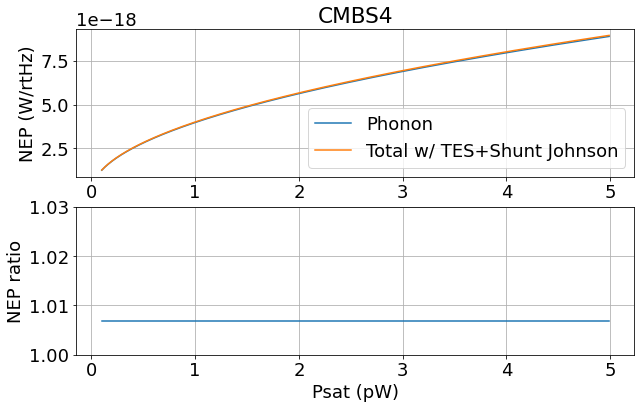

In [114]:
Psat_pW = np.arange(0.1,5,0.01)  #pW
Psat = Psat_pW*1e-12
Gdyn = Psat*n*T_bolo**beta/(T_bolo**n-T_bath**n)
safety_factor = 3.

NEP_phonon = np.sqrt(4*k*Gdyn*Flink*T_bolo**2) 

# Recalculate these with correct electrical power
Popt = Psat/safety_factor
Pelec = Psat - Popt

NEP_J_bolo = np.sqrt(4*k*T_bolo*Pelec)/L0
NEP_J_shunt = np.sqrt(4*k*T_shunt*Pelec*R_s/R_b)*(L0-1)**2/(L0**2)

NEP_total = np.sqrt(NEP_phonon**2 + NEP_J_bolo**2 + NEP_J_shunt**2)

print('(Rbolo , Tbolo) = ({0:2.4f}, {1:2.2f})'.format(R_b,T_bolo))
print('(Rshunt, Tbath) = ({0:2.4f}, {1:2.2f})'.format(R_s,T_bath))
print('(n, beta)  = ({0:2.2f}, {1:2.2f})'.format(n,beta))
print('(P_sat/P_opt,L) = ({0:2.2f}, {1:2.2f})'.format(safety_factor,L0))
print('Flink = {0:2.2f}'.format(Flink))


%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [10, 6]

plt.subplot(2,1,1)
plt.plot(Psat_pW,NEP_phonon,label='Phonon')
plt.plot(Psat_pW,NEP_total,label='Total w/ TES+Shunt Johnson')
plt.grid()
plt.title(expt)
plt.ylabel('NEP (W/rtHz)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(Psat_pW,NEP_total/NEP_phonon)
plt.xlabel('Psat (pW)')
plt.ylabel('NEP ratio')
plt.ylim([1.0,1.03])
plt.grid()